In [1]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shap
import settings

In [2]:
regression_targets = f'{settings.raw_data_folder}control/regression_targets.csv'
control = f'{settings.processed_data_folder}food_selected_features.csv'

In [3]:
targets = pd.read_csv(regression_targets, index_col=False)

In [4]:
df = pd.read_csv(control, index_col=0)

In [5]:
df = pd.merge(targets, df, on='Country')

In [6]:
df.head()

,Deaths,Confirmed,Recovered,Country,"Fish, Seafood",Alcoholic Beverages,Eggs,Milk - Excluding Butter
0,0.033360,0.013626,0.013648,Afghanistan,0.000638,0.000030,0.132792,0.353124
1,0.274778,0.285071,0.198303,Albania,0.022935,0.095202,0.460113,0.917774
2,0.035368,0.023500,0.018537,Algeria,0.024193,0.011670,0.313765,0.402251
3,0.007877,0.005897,0.006284,Angola,0.184776,0.251279,0.022781,0.044997
4,0.038521,0.028206,0.021108,Antigua and Barbuda,0.346861,0.226478,0.118321,0.378817


In [7]:
columns = df.columns.tolist()
columns.remove('Country')

In [8]:
features = df.columns.tolist()

In [9]:
features.remove('Confirmed')
features.remove('Recovered')
features.remove('Deaths')
features.remove('Country')

In [10]:
df = df[df['Deaths'] != 0]

In [11]:
df = df.drop(['Confirmed', 'Recovered'], axis=1)

In [12]:
X = df[features]

In [13]:
Y = df['Deaths']

In [14]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [15]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
y_pred = model.predict(X_test)

In [17]:
pred_real = []
pred_real.append(y_pred.tolist())
pred_real.append(y_test.tolist())
pred_real.append(range(0, len(y_test.tolist())))

In [18]:
indexes = y_test.index.tolist()

In [19]:
test_countries = df.loc[indexes, :]['Country']

In [20]:
pred_real_df = pd.DataFrame(pred_real).T

In [21]:
pred_real_df.columns = ['Predicted', 'Real', 'No']

In [22]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE {mae: .4f}")

MAE  0.1295


In [23]:
print('==REAL= <=> =PRED==')
i = 0
for real, pred in zip(y_test, y_pred):
    print(f"{i}:{real: .3f}  <=>  {pred: .3f}  ")
    i+=1

==REAL= <=> =PRED==
0: 0.009  <=>   0.055  
1: 0.018  <=>   0.009  
2: 0.862  <=>   0.604  
3: 0.026  <=>   0.083  
4: 0.297  <=>   0.125  
5: 0.000  <=>   0.165  
6: 0.009  <=>   0.041  
7: 0.123  <=>  -0.006  
8: 0.010  <=>   0.039  
9: 0.060  <=>   0.037  
10: 0.695  <=>   0.599  
11: 0.050  <=>   0.194  
12: 0.000  <=>   0.023  
13: 0.548  <=>   0.420  
14: 0.010  <=>   0.061  
15: 0.046  <=>   0.022  
16: 0.005  <=>   0.071  
17: 0.221  <=>   0.029  
18: 0.003  <=>   0.413  
19: 0.014  <=>   0.055  
20: 0.656  <=>   0.289  
21: 0.144  <=>   0.465  
22: 0.048  <=>   0.151  
23: 0.523  <=>   0.412  
24: 0.282  <=>   0.438  
25: 0.462  <=>   0.506  
26: 0.023  <=>   0.070  
27: 0.046  <=>   0.037  
28: 0.010  <=>   0.136  
29: 0.004  <=>   0.144  
30: 0.503  <=>   0.380  
31: 0.756  <=>   0.024  
32: 0.295  <=>   0.142  
33: 0.001  <=>   0.021  
34: 0.009  <=>   0.046  
35: 0.003  <=>   0.217  
36: 0.053  <=>   0.193  
37: 0.203  <=>   0.100  
38: 0.062  <=>   0.049  


In [24]:
pred_real_df['Country'] = test_countries.tolist()

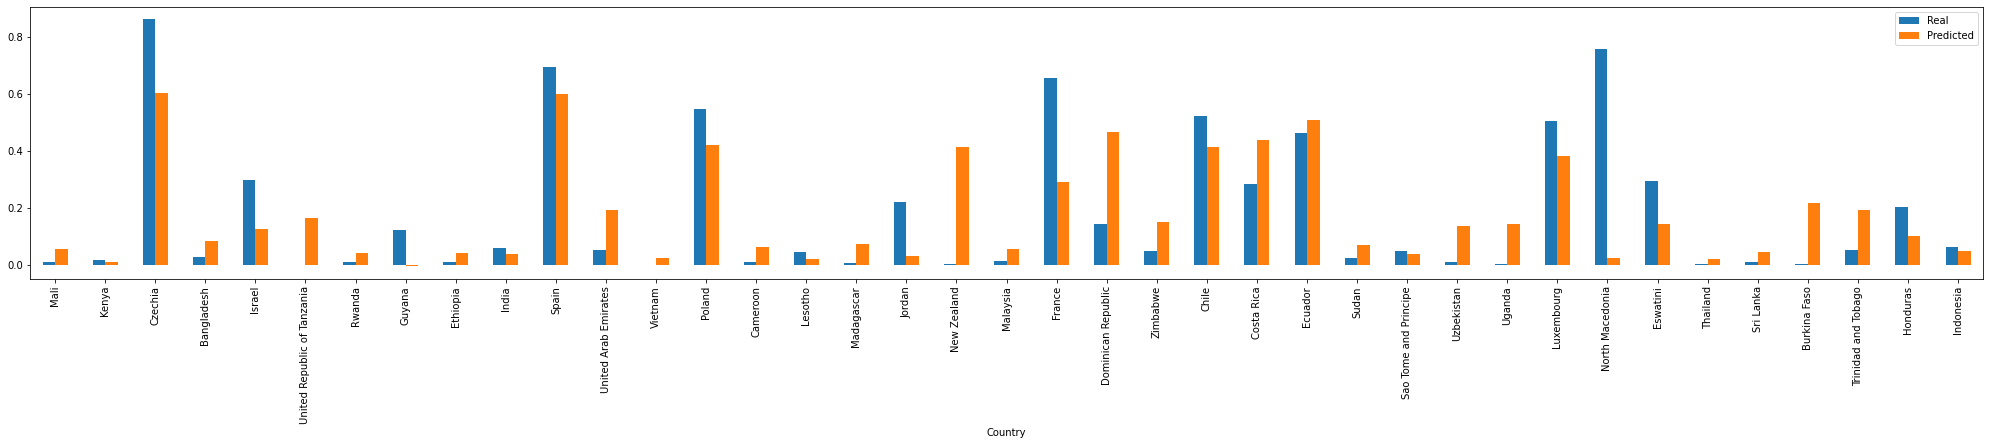

In [25]:
pred_real_df.plot(x="Country", y=["Real", "Predicted"], kind="bar", figsize=(35,5), width = 0.5)
plt.savefig(f'./food_predictions.png', dpi=300, bbox_inches = "tight")

In [26]:
print(model.feature_importances_)

[0.08702882 0.19308269 0.2964192  0.42346928]


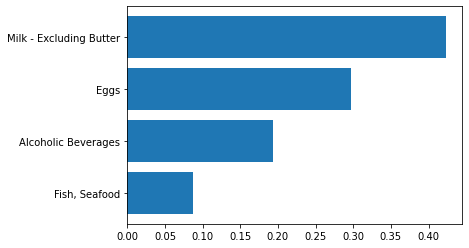

In [27]:
plt.barh(features, model.feature_importances_)
plt.show()

In [28]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

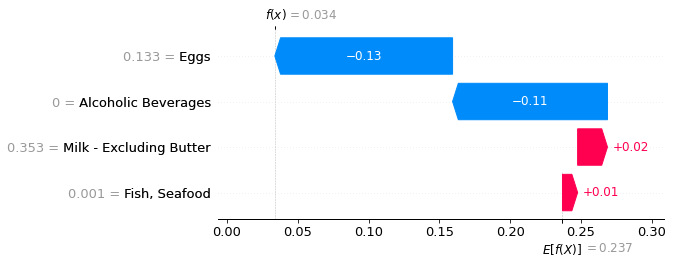

In [29]:
shap.plots.waterfall(shap_values[0])

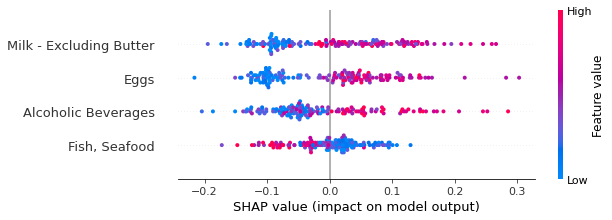

<Figure size 432x288 with 0 Axes>

In [30]:
shap.plots.beeswarm(shap_values)
plt.savefig(f'./food_xgboost_shap.png', dpi=300, bbox_inches = "tight")

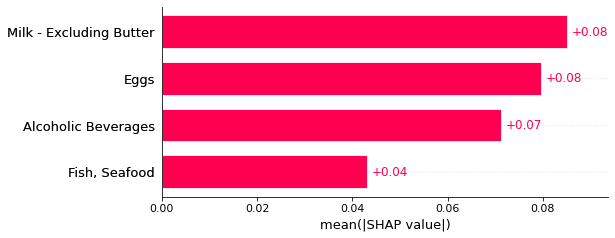

In [31]:
shap.plots.bar(shap_values)